# Test the ability of qiskit.transpiler

To trasnpile an ideal circuit ``c0`` with different noise models.

- ``c1``: only contains the nearest-neighbour (N.N.) couplings
- ``c2``: also contains the next-nearest-neighbour (N.N.N.) couplings

The N.N.N. gate error rates are larger than the N.N. error rates by a ``scale factor``.

``c1`` is deeper but has lower noise

``c2`` is shallower but has higher noise


Compare their output with the ideal circuit ``c0``: As for noisy circuits, if the output is in ``c0`` ideal outputs, then ``count+=1``.


Now, sweep the ``scale factor`` (N.N.N. noise), the performance of ``c2`` should decay compared to ``c1``.

According to simulation, the cross section is roughly ``scale = 2.5``.

**However, it seems that the transpiler fails to optimize the noisy circuit by deepening the circuit to avoid using noisy gates!**

In [1]:
from qiskit import QuantumRegister, QuantumCircuit
from qiskit import execute, transpile
from qiskit.quantum_info import Statevector
from qiskit import Aer
import numpy as np
import matplotlib.pyplot as plt

q = QuantumRegister(4,'q')

c0 = QuantumCircuit(q)
c0.cz(q[1],q[2])
c0.x(q[1])
c0.cz(q[0],q[1])
c0.sx(q[1])
c0.cz(q[1],q[2])
c0.sx(q[2])
c0.cz(q[2],q[3])
c0.x(q[3])
c0.x(q[0])
c0.cz(q[3],q[0])

c0.measure_all()

state_vector = Statevector.from_instruction(
    c0.remove_final_measurements(inplace=False) )
ideal_prob = state_vector.probabilities_dict()

display(ideal_prob)


basis_gates = ['x','sx','rz','cz']
cmap1 = [[0,1],[1,0],[1,2],[2,1],[2,3],[3,2]] # N.N. coupling map
cmap2 = [[0,1],[0,2],[1,0],[1,2],[1,3],[2,0],[2,1],[2,3],[3,1],[3,2]] # N.N.N. coupling map

c1 = transpile(c0, coupling_map=cmap1,basis_gates=basis_gates, optimization_level=3)
c2 = transpile(c0, coupling_map=cmap2,basis_gates=basis_gates, optimization_level=3)

display(c0.draw())
display(c1.draw(fold=-1))
display(c2.draw(fold=-1))

{'1001': 0.25, '1011': 0.25, '1101': 0.25, '1111': 0.25}

┌───┐                      ░ ┌─┐         
   q_0: ─────────■─┤ X ├───────────────────■──░─┤M├─────────
           ┌───┐ │ ├───┴┐                  │  ░ └╥┘┌─┐      
   q_1: ─■─┤ X ├─■─┤ √X ├─■────────────────┼──░──╫─┤M├──────
         │ └───┘   └────┘ │ ┌────┐         │  ░  ║ └╥┘┌─┐   
   q_2: ─■────────────────■─┤ √X ├─■───────┼──░──╫──╫─┤M├───
                            └────┘ │ ┌───┐ │  ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────────────────■─┤ X ├─■──░──╫──╫──╫─┤M├
                                     └───┘    ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════╩══╩══╩══╩═
                                                 0  1  2  3

global phase: 0
                                  ┌───┐                                          ┌─────────┐  ┌────┐ ┌───────┐          ┌────┐    ┌─────────┐                        ░    ┌─┐      
q_0 -> 0 ───────────────────────■─┤ X ├────────────────────────────────────────■─┤ Rz(π/2) ├──┤ √X ├─┤ Rz(π) ├──■───────┤ √X ├────┤ Rz(π/2) ├─■──────────────────────░────┤M├──────
                         ┌───┐  │ ├───┴┐   ┌─────────┐     ┌────┐    ┌───────┐ │ └──┬────┬─┘┌─┴────┴┐└───────┘  │       ├────┤    └┬───────┬┘ │ ┌────┐┌─────────┐    ░ ┌─┐└╥┘      
q_1 -> 1 ───────■────────┤ X ├──■─┤ √X ├─■─┤ Rz(π/2) ├─────┤ √X ├────┤ Rz(π) ├─■────┤ √X ├──┤ Rz(π) ├───────────■───────┤ √X ├─────┤ Rz(π) ├──■─┤ √X ├┤ Rz(π/2) ├─■──░─┤M├─╫───────
                │        └───┘    └────┘ │ └──┬────┬─┘┌────┴────┴───┐└─┬────┬┘      ├────┤  ├───────┤         ┌────┐┌───┴────┴───┐ └───────┘    └────┘└─────────┘ │  ░ └╥┘ ║    ┌─┐
q_2 -> 2 ───────■────────────────────────■────┤ √X ├──┤ Rz(-2.9927) ├──┤ √X ├──■────┤ √X ├──┤ Rz(π) ├────■────┤ √X ├┤ Rz(2.8953) ├────────────────────────────────■──░──╫──╫────┤M├
         ┌──────────────┐┌────┐               └────┘  └─────────────┘  └────┘  │    ├────┤  └───────┘    │    ├────┤├────────────┤                                   ░  ║  ║ ┌─┐└╥┘
q_3 -> 3 ┤ Rz(-0.24628) ├┤ √X ├────────────────────────────────────────────────■────┤ √X ├───────────────■────┤ √X ├┤ Rz(2.9927) ├───────────────────────────────────░──╫──╫─┤M├─╫─
         └──────────────┘└────┘                                                     └────┘                    └────┘└────────────┘                                   ░  ║  ║ └╥┘ ║ 
 meas: 4/═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                                        0  1  2  3

┌───┐                      ░ ┌─┐         
q_0 -> 0 ─────────■─┤ X ├───────────────────■──░─┤M├─────────
            ┌───┐ │ ├───┴┐                  │  ░ └╥┘┌─┐      
q_1 -> 1 ─■─┤ X ├─■─┤ √X ├─■────────────────┼──░──╫─┤M├──────
          │ └───┘   └────┘ │          ┌───┐ │  ░  ║ └╥┘   ┌─┐
q_3 -> 2 ─┼────────────────┼────────■─┤ X ├─■──░──╫──╫────┤M├
          │                │ ┌────┐ │ └───┘    ░  ║  ║ ┌─┐└╥┘
q_2 -> 3 ─■────────────────■─┤ √X ├─■──────────░──╫──╫─┤M├─╫─
                             └────┘            ░  ║  ║ └╥┘ ║ 
 meas: 4/═════════════════════════════════════════╩══╩══╩══╩═
                                                  0  1  2  3

Ideal outputs: {'1001': 0.25, '1011': 0.25, '1101': 0.25, '1111': 0.25}


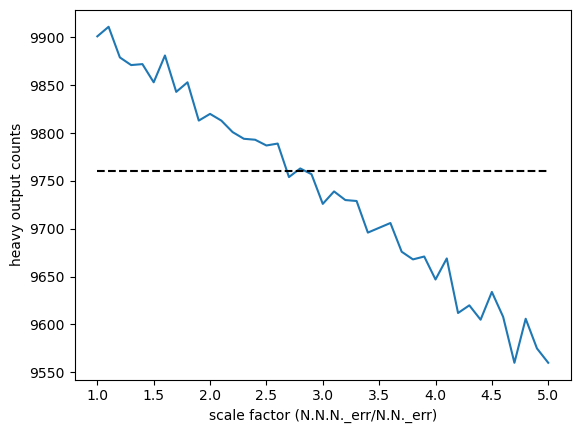

In [2]:
from qiskit_aer import AerSimulator, noise
import numpy as np
import matplotlib.pyplot as plt

def get_backend_1(error1, error2):
    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(error1, 1)
    error_2 = noise.depolarizing_error(error2, 2)

    # Add errors to noise model
    noise_model1 = noise.NoiseModel()
    noise_model1.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'])
    noise_model1.add_all_qubit_quantum_error(error_2, ['cz'])

    backend = AerSimulator(basis_gates=basis_gates, n_qubits=4,
                           noise_model=noise_model1, coupling_map=cmap1)
    
    return backend

def get_backend_2(error1, error2, error3):
    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(error1, 1)
    error_2 = noise.depolarizing_error(error2, 2)
    error_3 = noise.depolarizing_error(error3, 2)

    noise_model2 = noise.NoiseModel()
    noise_model2.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'])
    for qubits in cmap2:
        if qubits not in cmap2:
            noise_model2.add_quantum_error(error_2, ['cz'], qubits)
        else:
            noise_model2.add_quantum_error(error_3, ['cz'], qubits)

    backend = AerSimulator(basis_gates=basis_gates, n_qubits=4,
                           noise_model=noise_model2, coupling_map=cmap1)
    
    return backend

def get_hop_counts(counts, ideal_prob):
    count = 0
    for state in counts.keys():
        if state in ideal_prob.keys():
            count += counts[state]
    return count


error1 = 0.0005
error2 = 0.005
be1 = get_backend_1(error1, error2)
counts1 = be1.run(transpile(c1, backend=be1), shots=10000).result().get_counts()
hop1 = get_hop_counts(counts1, ideal_prob)

hop2 = []
scales = np.r_[1.0:5.1:0.1]
for scale in scales:
    be2 = get_backend_2(error1, error2, scale*error2)
    counts2 = be2.run(transpile(c2, backend=be2), shots=10000).result().get_counts()
    hop2.append(get_hop_counts(counts2, ideal_prob))

print(f"Ideal outputs: {ideal_prob}")

plt.plot(scales, hop2)
plt.hlines(hop1, scales[0], scales[-1], linestyles="dashed", colors='k')
plt.xlabel('scale factor (N.N.N._err/N.N._err)')
plt.ylabel('heavy output counts')
plt.show()

In [8]:
be_low = get_backend_2(error1, error2, error2)
be_high = get_backend_2(error1, error2, 100*error2)

c_low = transpile(c0, backend=be_low, optimization_level=3, coupling_map=cmap2)
c_high = transpile(c0, backend=be_high, optimization_level=3, coupling_map=cmap2)

display(c_low.draw(fold=-1))
display(c_high.draw(fold=-1))

┌────┐            ░       ┌─┐   
q_2 -> 0 ─■────────────────■─┤ √X ├─■──────────░───────┤M├───
          │                │ └────┘ │ ┌───┐    ░       └╥┘┌─┐
q_3 -> 1 ─┼────────────────┼────────■─┤ X ├─■──░────────╫─┤M├
          │ ┌───┐   ┌────┐ │          └───┘ │  ░    ┌─┐ ║ └╥┘
q_1 -> 2 ─■─┤ X ├─■─┤ √X ├─■────────────────┼──░────┤M├─╫──╫─
            └───┘ │ ├───┬┘                  │  ░ ┌─┐└╥┘ ║  ║ 
q_0 -> 3 ─────────■─┤ X ├───────────────────■──░─┤M├─╫──╫──╫─
                    └───┘                      ░ └╥┘ ║  ║  ║ 
 meas: 4/═════════════════════════════════════════╩══╩══╩══╩═
                                                  0  1  2  3

┌───┐                      ░ ┌─┐         
q_0 -> 0 ─────────■─┤ X ├───────────────────■──░─┤M├─────────
            ┌───┐ │ ├───┴┐                  │  ░ └╥┘┌─┐      
q_1 -> 1 ─■─┤ X ├─■─┤ √X ├─■────────────────┼──░──╫─┤M├──────
          │ └───┘   └────┘ │          ┌───┐ │  ░  ║ └╥┘   ┌─┐
q_3 -> 2 ─┼────────────────┼────────■─┤ X ├─■──░──╫──╫────┤M├
          │                │ ┌────┐ │ └───┘    ░  ║  ║ ┌─┐└╥┘
q_2 -> 3 ─■────────────────■─┤ √X ├─■──────────░──╫──╫─┤M├─╫─
                             └────┘            ░  ║  ║ └╥┘ ║ 
 meas: 4/═════════════════════════════════════════╩══╩══╩══╩═
                                                  0  1  2  3